In [32]:
!pip install scikit-learn


In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import joblib
import matplotlib.pyplot as plt


In [34]:
!pip install openpyxl



In [35]:
dt = pd.read_excel('heart_statlog_cleveland_hungary_final.xlsx')

In [36]:
dt.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [37]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


In [38]:
missing_values = dt.isnull().sum()
print(missing_values)


age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64


Cross-Validation Accuracy Scores: [0.82773109 0.85294118 0.80672269 0.80252101 0.78151261]
Mean CV Accuracy Score: 0.8142857142857143
Mean Precision: 0.8138401407973094
Mean Recall: 0.8128393937052337
Mean F1 Score: 0.8130825001119037


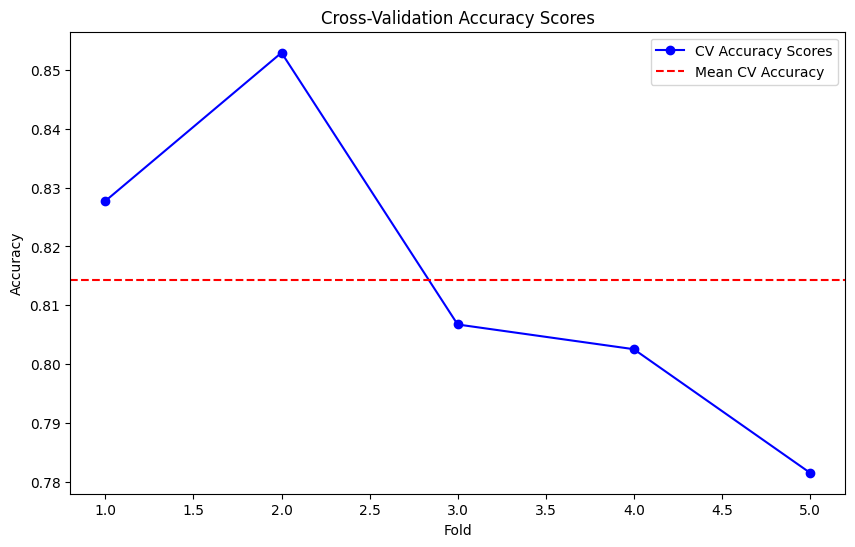

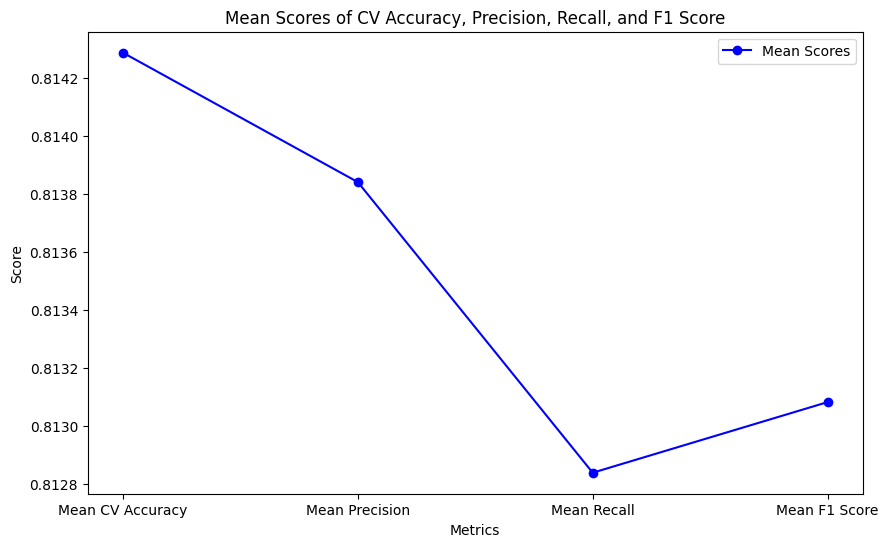

Index(['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak',
       'ST slope', 'target', 'sex_encoded', 'chest pain type_encoded',
       'fasting blood sugar_encoded', 'resting ecg_encoded',
       'exercise angina_encoded', 'chest pain type_encoded_1',
       'chest pain type_encoded_2', 'chest pain type_encoded_3'],
      dtype='object')


In [46]:
# Fungsi untuk memuat dan memproses data
def load_and_preprocess_data():
    data = pd.read_excel('heart_statlog_cleveland_hungary_final.xlsx', sheet_name='heart_statlog_cleveland_hungary')

    # Inisialisasi LabelEncoder
    le_sex = LabelEncoder()
    le_chest_pain_type = LabelEncoder()
    le_fasting_blood_sugar = LabelEncoder()
    le_resting_ecg = LabelEncoder()
    le_exercise_angina = LabelEncoder()

    # Transformasi kolom
    data['sex_encoded'] = le_sex.fit_transform(data['sex'])
    data['chest pain type_encoded'] = le_chest_pain_type.fit_transform(data['chest pain type'])
    data['fasting blood sugar_encoded'] = le_fasting_blood_sugar.fit_transform(data['fasting blood sugar'])
    data['resting ecg_encoded'] = le_resting_ecg.fit_transform(data['resting ecg'])
    data['exercise angina_encoded'] = le_exercise_angina.fit_transform(data['exercise angina'])

    # Inisialisasi OneHotEncoder
    ohe = OneHotEncoder(sparse_output=False, drop='first')

    # Transformasi kolom "chest pain type_encoded"
    chest_pain_type_encoded = ohe.fit_transform(data[['chest pain type_encoded']])

    # Konversi hasil OneHotEncoder ke DataFrame
    chest_pain_type_encoded_df = pd.DataFrame(chest_pain_type_encoded, columns=ohe.get_feature_names_out(['chest pain type_encoded']))

    # Gabungkan hasil OneHotEncoder dengan DataFrame asli
    data = pd.concat([data, chest_pain_type_encoded_df], axis=1)

    data['combined_chest_pain_type'] = data[['chest pain type_encoded', 'chest pain type_encoded_1', 'chest pain type_encoded_2', 'chest pain type_encoded_3']].idxmax(axis=1)


    # Drop kolom yang tidak diperlukan setelah encoding
    data = data.drop(columns=['sex', 'chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', 'chest pain type_encoded', 'chest pain type_encoded_1', 'chest pain type_encoded_2','chest pain type_encoded_3'], axis=1')

    # Pisahkan fitur dan target
    X = data.drop(columns=['target'])
    y = data['target']
    
    return X, y

# Fungsi untuk mengevaluasi model
def evaluate_model(X, y):
    model = GaussianNB()
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Lakukan Cross-Validation dan evaluasi dengan metrik akurasi
    accuracy_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        precision_scores.append(precision_score(y_test, y_pred, average='macro'))
        recall_scores.append(recall_score(y_test, y_pred, average='macro'))
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))

    return model, accuracy_scores, np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores)

# Muat dan proses data
X, y = load_and_preprocess_data()

# Evaluasi model
model, accuracy_scores, mean_precision, mean_recall, mean_f1 = evaluate_model(X, y)

# Simpan hasil evaluasi dan model
joblib.dump(model, 'naive_bayes_model.pkl')

print(f'Cross-Validation Accuracy Scores: {accuracy_scores}')
print(f'Mean CV Accuracy Score: {accuracy_scores.mean()}')
print(f'Mean Precision: {mean_precision}')
print(f'Mean Recall: {mean_recall}')
print(f'Mean F1 Score: {mean_f1}')

# Plot Cross-Validation Accuracy Scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), accuracy_scores, marker='o', linestyle='-', color='b', label='CV Accuracy Scores')
plt.axhline(y=accuracy_scores.mean(), color='r', linestyle='--', label='Mean CV Accuracy')
plt.title('Cross-Validation Accuracy Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('cv_accuracy_scores_line_chart.png')
plt.show()

# Plot Mean Scores
mean_scores = [accuracy_scores.mean(), mean_precision, mean_recall, mean_f1]
mean_labels = ['Mean CV Accuracy', 'Mean Precision', 'Mean Recall', 'Mean F1 Score']

plt.figure(figsize=(10, 6))
plt.plot(mean_labels, mean_scores, marker='o', linestyle='-', color='b', label='Mean Scores')
plt.title('Mean Scores of CV Accuracy, Precision, Recall, and F1 Score')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.legend()
plt.savefig('mean_scores_line_chart.png')
plt.show()





In [45]:
# Load the model from disk
model = joblib.load('naive_bayes_model.pkl')

# Contoh data individu baru untuk prediksi
new_data = [[40, 140, 289, 172, 0.0, 1, 1, 1, 0, 0, 0, 1.0, 0.0, 0.0]]

# Lakukan prediksi risiko penyakit jantung
risk_prediction = model.predict(new_data)

if risk_prediction[0] == 1:
    print("Risiko tinggi terkena penyakit jantung.")
else:
    print("Risiko rendah terkena penyakit jantung.")

Risiko rendah terkena penyakit jantung.


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
